We'll be using [Ray](https://ray.io) to develop our application using distributed workloads.

# 🛠️ Setup

In [1]:
import os
import ray

In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [3]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-07-04 13:30:46,651	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.11
Ray version:,2.7.1
Dashboard:,http://127.0.0.1:8266


In [4]:
ray.cluster_resources()

{'memory': 7201212007.0,
 'CPU': 10.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 2147483648.0,
 'node:127.0.0.1': 1.0}

In [5]:
# Workers (1 g4dn.xlarge)
num_workers = 6
resources_per_worker={"CPU": 1, "GPU": 0}

In [6]:
# Storage
EFS_DIR = f"/efs/shared_storage/madewithml/sinapordanesh"
print (EFS_DIR)

/efs/shared_storage/madewithml/sinapordanesh


# Data

| Assumption | Reality | Reason |
| --- | --- | --- |
| All of our incoming data is only machine learning related (no spam). | We would need a filter to remove spam content that's not ML related. | To simplify our ML task, we will assume all the data is ML content. |

## Data ingestion

In [7]:
import pandas as pd

In [8]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## Spliting the data

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [11]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [12]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

![Validation value counts](./images/Validation%20(adjusted)%20value%20counts.png)

In [13]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## 🔍 Exploratory Data Analysis (EDA)

Exploratory data analysis to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined.

- not just to visualize a prescribed set of plots (correlation matrix, etc.).
- goal is to convince yourself that the data you have is sufficient for the task.
- use EDA to answer important questions and to make it easier to extract insight
- not a one time process; as your data grows, you want to revisit EDA to catch distribution shifts, anomalies, etc.

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [15]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

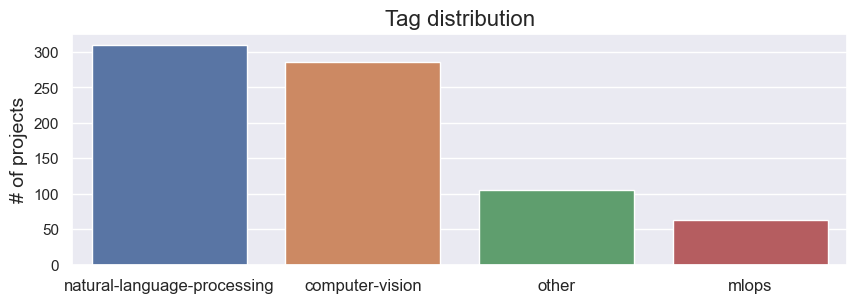

In [16]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

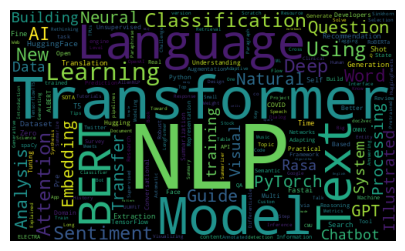

In [17]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)


Looks like the `title` text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the `description` text feature as well. This information will become useful when we decide how to use our features for modeling.

## ✨ Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks.

In [18]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn). 

In [19]:
# Feature engineering
df["text"] = df.title + " " + df.description

### Clean text

In [20]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /Users/sina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [22]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Clean DataFrame

In [23]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [24]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [25]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [26]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [27]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a [tokenizer](https://huggingface.co/allenai/scibert_scivocab_uncased/blob/main/vocab.txt) that was used for a pretrained LLM ([scibert](https://huggingface.co/allenai/scibert_scivocab_uncased)) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [28]:
import numpy as np
from transformers import BertTokenizer

In [29]:
# Bert tokenizer
# A sample on how this library works on a sample data
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [30]:
# The main function that we want to use for tokenization process
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [31]:
# Tokenization 
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

We'll combine all of our preprocessing steps into function:

In [32]:
# This function is the combination of all steps we've taken on data processing, uder a same roof.
# This function will be used for the later data processing progress on our training data, before training. 
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [33]:
# Apply 
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

# Distributed preprocessing

The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [34]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

In [35]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2024-07-04 13:30:56,666	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2024-07-04 13:30:56,683	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-07-04 13:30:56,686	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 13:30:56,687	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:30:56,688	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 549,
  'created_on': datetime.datetime(2020, 4, 16, 3, 48, 35),
  'title': '15 Best Tools for Tracking Machine Learning Experiments',
  'description': 'A feature comparison of all the open-source and commercial options for experiment tracking.',
  'tag': 'mlops'}]

In [36]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split # A modified version of train_test_split function of Ray

In [37]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-07-04 13:30:59,499	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 13:30:59,500	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:30:59,500	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
# Mapping 
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-07-04 13:31:00,642	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 13:31:00,642	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:00,643	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 13:31:02,568	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-07-04 13:31:02,569	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:02,570	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

In [39]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2024-07-04 13:31:10,131	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-07-04 13:31:10,142	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:10,147	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=44312) /Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=44312)   warnings.warn(
(MapBatches(preprocess) pid=44310) /Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=44310)   warnings.warn(
(MapBatches(preprocess) pid=44310) /Users/sina/Documents/GitHub_Local/mlops/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in 

{'ids': array([  102,  2389, 29477,  3254,  1572,  6773,  4459,  3041,   791,
        2389, 29477,  3350,  2389, 21591,  3254,  7398,  1572,  6773,
        9153,  1098,  5751,  1332,   532,  1186,   103,     0,     0,
           0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


# Training

When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be: 

1. random model (predict labels randomly)
2. rule-based model (pattern match labels in input text)
3. logistic regression (td-idf vectors from text)
4. CNN (apply character filters over text)
5. Fine-tune LLM (this notebook)

We'll first set up some functions that will help us achieve complete reproducibility.

In [40]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [41]:
# set the seeds for reproducibility across our libraries 
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [42]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [43]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

## 🤖 Model

In [44]:
import torch.nn as nn
from transformers import BertModel

In [45]:
# Pretrained LLM 
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


![Bert Model](./images/bert.png)

In [46]:
# Sample fine tuning the Bert model using one data sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [47]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [48]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## 📦 Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (`padding="longest"`). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom `collate_fn` to repad the items in our training batches.

In [49]:
from ray.train.torch import get_device

Created a temporary directory at /var/folders/94/p22yrw514tv4kplhpq9hmknr0000gn/T/tmpmyyzj1uz
Writing /var/folders/94/p22yrw514tv4kplhpq9hmknr0000gn/T/tmpmyyzj1uz/_remote_module_non_scriptable.py


In [50]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [51]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> `pad=(0, max_len)` in [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch-nn-functional-pad) refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the `constant` mode refers to each element being padded to a constant size (size of longest element in the input).

In [52]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-07-04 13:31:18,543	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2024-07-04 13:31:18,543	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:18,544	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

{'ids': tensor([[  102,  6121,  2216,  ..., 10288,   103,     0],
         [  102, 19015,   318,  ...,     0,     0,     0],
         [  102,   405,  4920,  ...,     0,     0,     0],
         ...,
         [  102,  2987,  7566,  ..., 18996,   669,   103],
         [  102,  2404,  2647,  ...,     0,     0,     0],
         [  102,   239, 30118,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 1, 1, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2,
         2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3,
         2, 2, 3, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 3, 0,
         0, 2, 1, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 1,
         2, 0, 

In [53]:
from ray.train.torch import get_device

In [54]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [55]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> `pad=(0, max_len)` in [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch-nn-functional-pad) refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the `constant` mode refers to each element being padded to a constant size (size of longest element in the input).

In [56]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-07-04 13:31:24,616	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2024-07-04 13:31:24,617	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:24,617	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

{'ids': tensor([[  102,  2389, 29477,  ...,     0,     0,     0],
         [  102, 20439,  4681,  ...,     0,     0,     0],
         [  102,   864,   864,  ...,     0,     0,     0],
         ...,
         [  102,  9205,  4872,  ...,     0,     0,     0],
         [  102,   502,  1371,  ...,     0,     0,     0],
         [  102,   287,   489,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2,
         2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3,
         2, 2, 3, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0,
         0, 2, 2, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2, 3, 2, 2, 1, 2, 0,
         2, 2, 

## 🧮 Utilities

![Necessary Utility Technologies](./images/utilities.svg)

In [57]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

In [58]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [59]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [60]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

## 🗂️ Configurations

In [61]:
from madewithml.config import EFS_DIR

In [62]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [63]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

In [64]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path=EFS_DIR)

Sample directory structure for our trained model, will look like this:

/home/ray/ray_results/llm

    ├── TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/
    ├── basic-variant-state-2023-07-20_18-14-50.json
    ├── experiment_state-2023-07-20_18-14-50.json
    ├── trainer.pkl
    └── tuner.pkl


TorchTrainer_ objects are the individuals runs in this experiment and each one will have the following contents:

/home/ray/ray_results/TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/

    ├── checkpoint_000009/  # we only save one checkpoint (the best)
    ├── events.out.tfevents.1689902160.ip-10-0-49-200
    ├── params.json
    ├── params.pkl
    ├── progress.csv
    └── result.json


## 🚂 Training

In [65]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-07-04 13:31:28,237	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2024-07-04 13:31:28,252	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 13:31:28,252	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:28,253	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-07-04 13:31:28,867	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-07-04 13:31:28,868	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:28,868	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 13:31:29,937	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-07-04 13:31:29,938	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:29,939	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 13:31:31,087	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-07-04 13:31:31,088	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:31,089	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 13:31:32,958	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-07-04 13:31:32,959	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 13:31:32,960	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

In [67]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

In [68]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [69]:
%%time
# Train
results = trainer.fit()

(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 13:46:50,862	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.


(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(pid=44953) Running: 0.0/10.0 CPU, 0.0/0.0 GPU, 0.29 MiB/512.0 MiB object_store_memory 0:   0%|          | 0/2…

(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(pid=44953) Running: 0.0/10.0 CPU, 0.0/0.0 GPU, 0.32 MiB/512.0 MiB object_store_memory 0:   0%|          | 0/2…

(pid=44953) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

2024-07-04 14:00:40,828	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2024-07-04 14:00:40,842	INFO tune.py:1143 -- Total run time: 1744.97 seconds (1744.85 seconds for the tuning loop).


CPU times: user 8.77 s, sys: 13 s, total: 21.7 s
Wall time: 29min 5s


In [72]:
# Metrics per epoch
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.584752,0.518042,1720121676,True,False,1,06d4a_00000,2024-07-04_13-34-37,...,177.354692,1,checkpoint_000000,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.514184,0.486024,1720121853,True,False,2,06d4a_00000,2024-07-04_13-37-35,...,354.575989,2,checkpoint_000001,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.468900,0.396391,1720122022,True,False,3,06d4a_00000,2024-07-04_13-40-24,...,523.080145,3,checkpoint_000002,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.376633,0.322431,1720122202,True,False,4,06d4a_00000,2024-07-04_13-43-24,...,703.216660,4,checkpoint_000003,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.320406,0.254153,1720122395,True,False,5,06d4a_00000,2024-07-04_13-46-40,...,899.300182,5,checkpoint_000004,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.233888,0.211267,1720122567,True,False,6,06d4a_00000,2024-07-04_13-49-28,...,1067.556744,6,checkpoint_000005,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.177760,0.206122,1720122754,True,False,7,06d4a_00000,2024-07-04_13-52-35,...,1253.920103,7,checkpoint_000006,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.119894,0.172409,1720122921,True,False,8,06d4a_00000,2024-07-04_13-55-23,...,1422.154406,8,checkpoint_000007,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.091345,0.170199,1720123071,True,False,9,06d4a_00000,2024-07-04_13-57-52,...,1570.823222,9,checkpoint_000008,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.068686,0.168370,1720123237,True,False,10,06d4a_00000,2024-07-04_14-00-39,...,1737.449822,10,checkpoint_000009,0.5,0.0001,0.8,3,10,256,4


In [73]:
# Best checkpoints
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/Users/sina/Documents/GitHub_Local/mlops/notebooks/../efs/llm/TorchTrainer_06d4a_00000_0_2024-07-04_13-31-35/checkpoint_000009),
  {'epoch': 9,
   'lr': 0.0001,
   'train_loss': 0.06868558377027512,
   'val_loss': 0.1683700978755951,
   'timestamp': 1720123237,
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 10,
   'trial_id': '06d4a_00000',
   'date': '2024-07-04_14-00-39',
   'time_this_iter_s': 166.62660002708435,
   'time_total_s': 1737.4498221874237,
   'pid': 44830,
   'hostname': 'Samans-MacBook-Pro.local',
   'node_ip': '127.0.0.1',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 1737.4498221874237,
   'iterations_since_restore': 10})]

### Evaluation

In [75]:
from sklearn.metrics import precision_recall_fscore_support

In [76]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()
        
    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}
        
    def get_preprocessor(self):
        return self.preprocessor
        
    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [77]:
# Artifacts
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [78]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

2024-07-04 14:11:48,018	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2024-07-04 14:11:48,030	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-07-04 14:11:48,031	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 14:11:48,031	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'targets': 3}]

In [79]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

2024-07-04 14:11:56,943	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-07-04 14:11:56,946	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 14:11:56,948	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


In [80]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])

2024-07-04 14:12:06,055	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2024-07-04 14:12:06,059	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 14:12:06,059	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

In [81]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9528893411514998,
 'recall': 0.9528795811518325,
 'f1': 0.9516852188520305}

In [82]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])
    
    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [83]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2024-07-04 14:12:42,615	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-07-04 14:12:42,616	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 14:12:42,616	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

2024-07-04 14:12:44,011	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2024-07-04 14:12:44,011	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-04 14:12:44,012	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

{
  "precision": 0.9528893411514998,
  "recall": 0.9528795811518325,
  "f1": 0.9516852188520305
}
